In [47]:
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import OneHotEncoder
import joblib
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image as PILImage  # Rename PIL's Image to avoid conflict
from IPython.display import Image, display  # For inline display if needed
import urllib.request

In [3]:
data = pd.read_csv("merged4.csv")

In [5]:
data.shape

(28326, 12)

In [11]:
# Select only relevant attributes for similarity calculation
attributes = ['gender', 'season', 'year', 'usage']
encoder = OneHotEncoder()

In [10]:
# Apply one-hot encoding to the selected attributes
encoded_attributes = encoder.fit_transform(data[attributes]).toarray()

In [12]:
# Calculate cosine similarity on encoded attributes
similarity_matrix = cosine_similarity(encoded_attributes)

In [14]:
similarity_matrix.shape

(28326, 28326)

In [7]:
def get_recommendations(selected_id, df, similarity_matrix, target_category):
    # Check if the selected ID exists in the dataset
    if selected_id not in df['id'].values:
        print("Selected ID not found in the dataset.")
        return None
    
    # Get the index of the selected item
    selected_index = df[df['id'] == selected_id].index[0]

    
    # Get the selected item category
    selected_category = df.loc[selected_index, 'masterCategory']
    
    # Filter items to the target category only
    target_items = df[df['masterCategory'] == target_category].index.tolist()
    
    
    if len(target_items) == 0:
        print("No items found for the target category:", target_category)
        return None

    # Calculate similarity only for target category items
    similarities = similarity_matrix[selected_index, target_items]
    
    # Get the indices of the most similar items in the target category
    sorted_indices = similarities.argsort()[::-1][:3]
    recommended_indices = [target_items[i] for i in sorted_indices]
    similarity_scores = similarities[sorted_indices]  # Get top similarity scores

    # Prepare the DataFrame to include similarity scores
    recommendations = df.loc[recommended_indices, ['id', 'productDisplayName', 'masterCategory', 'subCategory', 'link']].copy()
    recommendations['similarity_score'] = similarity_scores  # Add similarity scores column

    return recommendations


In [9]:
# Function to get the link of the selected item by id
def get_link_by_id(selected_id, df):
    # Filter the dataframe by the selected_id
    selected_item = df[df['id'] == selected_id]
    
    # Check if the selected item exists and get the 'link' column
    if not selected_item.empty:
        return selected_item['link'].iloc[0]
    else:
        return None  # Return None if the selected id doesn't exist

In [77]:
with open('cosine_sim.pkl', 'wb') as file:
    pickle.dump(similarity_matrix, file)

In [13]:
similarity_matrix = joblib.load("similarity_matrix.pkl")

In [15]:
# Example usage:
selected_id = 11658  # Example selected ID (assuming it's a topwear)
recommendations_bt = get_recommendations(selected_id, data, similarity_matrix, 'Bottomwear')
recommendations_ac = get_recommendations(selected_id, data, similarity_matrix, 'Accessories')
recommendations_ft = get_recommendations(selected_id, data, similarity_matrix, 'Footwear')
print(recommendations_bt)
print(recommendations_ac)
print(recommendations_ft)

# Print the recommendations with the desired columns
images_bt = recommendations_bt['link'].tolist()
images_ac = recommendations_ac['link'].tolist()
images_ft = recommendations_ft['link'].tolist()

          id                                 productDisplayName  \
18329  14630  United Colors of Benetton Women Check Brown Sk...   
11803  16252  United Colors of Benetton Women Solid Brown St...   
6978    8497         Forever New Women Cameo Skirt Cream Skirts   

      masterCategory subCategory  \
18329     Bottomwear  Bottomwear   
11803     Bottomwear  Bottomwear   
6978      Bottomwear  Bottomwear   

                                                    link  similarity_score  
18329  http://assets.myntassets.com/v1/images/style/p...               1.0  
11803  http://assets.myntassets.com/v1/images/style/p...               1.0  
6978   http://assets.myntassets.com/v1/images/style/p...               1.0  
          id                             productDisplayName masterCategory  \
10593  12493  United Colors of Benetton Women Black Handbag    Accessories   
16931  11140             Scullers Women Solid White Scarves    Accessories   
6839   15436        Hidekraft Women Leather 

In [49]:
link = get_link_by_id(selected_id, data)
display(Image(url=link, width=200, height=200))

for image_url in images_bt:
    display(Image(url=image_url, width=200, height=200))

In [51]:
for image_url in images_ft:
    display(Image(url=image_url, width=200, height=200))

In [53]:
for image_url in images_ac:
    display(Image(url=image_url, width=200, height=200))

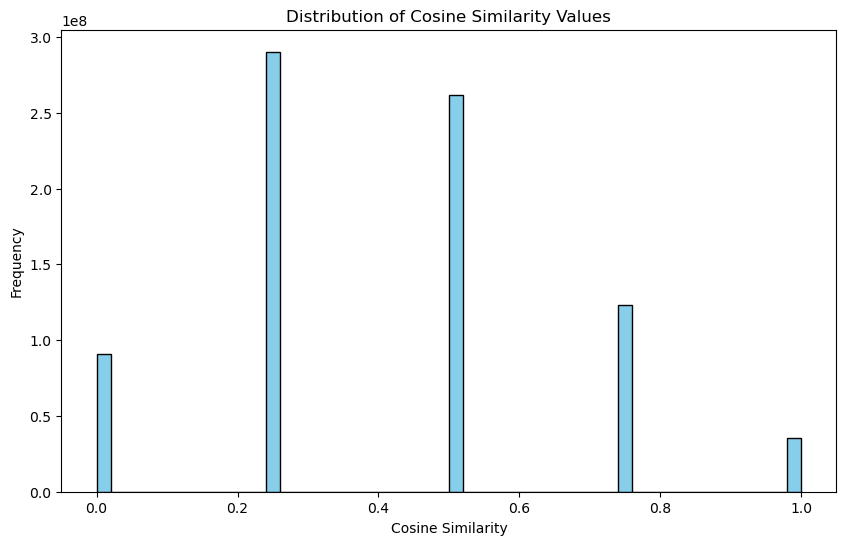

In [55]:
# Flatten the matrix and plot a histogram
cosine_sim_values = similarity_matrix.flatten()
plt.figure(figsize=(10, 6))
plt.hist(cosine_sim_values, bins=50, color='skyblue', edgecolor='black')
plt.title("Distribution of Cosine Similarity Values")
plt.xlabel("Cosine Similarity")
plt.ylabel("Frequency")
plt.show()


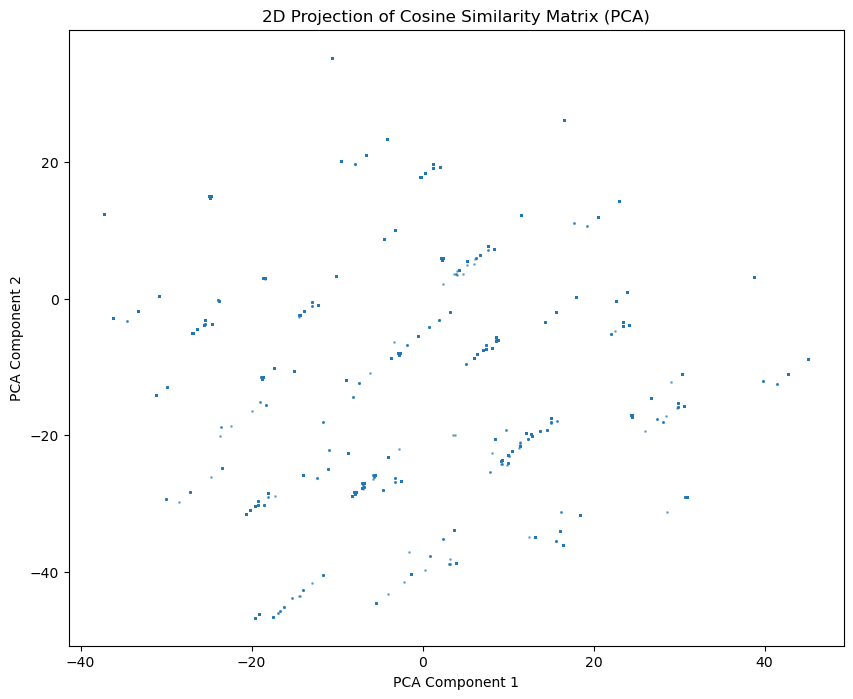

In [57]:
from sklearn.decomposition import PCA

# Perform PCA on the matrix
pca = PCA(n_components=2)
reduced_matrix = pca.fit_transform(similarity_matrix)

# Scatter plot of PCA-reduced data
plt.figure(figsize=(10, 8))
plt.scatter(reduced_matrix[:, 0], reduced_matrix[:, 1], alpha=0.5, s=1)
plt.title("2D Projection of Cosine Similarity Matrix (PCA)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()


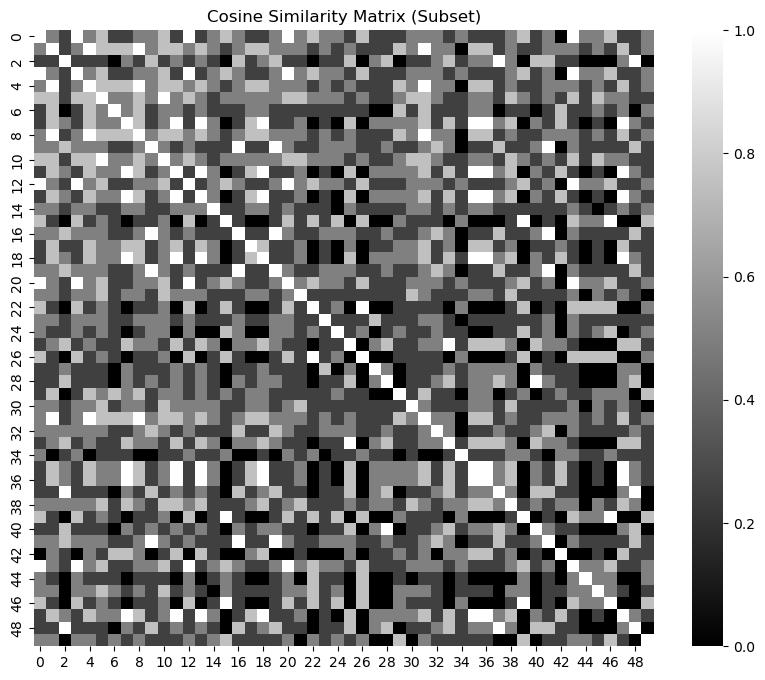

In [63]:
# Select a subset (e.g., first 500 rows and columns)
subset_size = 50
cosine_sim_matrix_subset = similarity_matrix[:subset_size, :subset_size]

# Plot the subset
plt.figure(figsize=(10, 8))
sns.heatmap(cosine_sim_matrix_subset, annot=False, cmap='grey')
plt.title("Cosine Similarity Matrix (Subset)")
plt.show()
